# GO/STOP! - Object Detection 시스템 만들기
--- 
### 실습 목표
- Object detection 모델을 학습할 수 있습니다.
- RetinaNet 모델을 활용한 시스템을 만들 수 있습니다.

### 학습 내용
- 자율주행 보조장치
- RetinaNet
- 데이터 준비부터 모델 학습, 결과 확인까지
- 프로젝트: 자율주행 보조 시스템 만들기


## 7-2. 자율주행 보조장치 

(1) KITTI 데이터셋

이번 시간에 만들어 볼 자율주행 보조장치는 카메라에 사람이 탐지되었을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 크기 이상일 때를 판단해야 합니다.

#### 자율주행 보조장치 object detection 요구사항

1. 사람이 카메라에 감지되면 정지
2. 차량이 일정 크기 이상으로 감지되면 정지
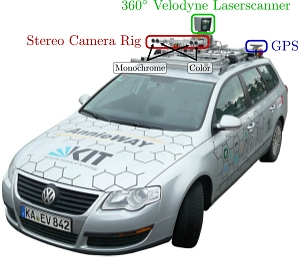

http://www.cvlibs.net/datasets/kitti/

이번 시간에는 tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용해보겠습니다. 

KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.

cvlibs에서 제공하는 KITTI 데이터셋(http://www.cvlibs.net/datasets/kitti/)

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

print('슝=3')

슝=3


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


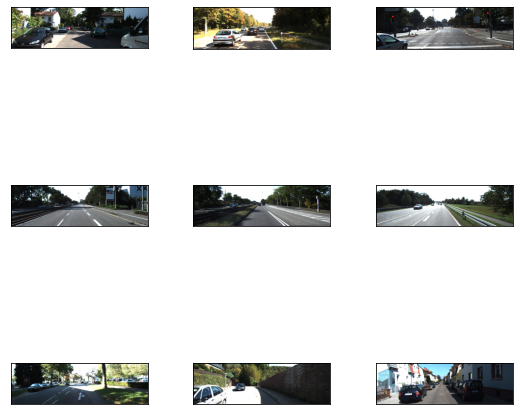

In [3]:
#  KITTI 데이터셋을 tfds.show_examples로 확인

_ = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 ds_info에서는 불러온 데이터셋의 정보를 확인할 수 있습니다. 오늘 사용할 데이터셋은 6,347개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다. 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있습니다.

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## 17-3. 자율주행 보조장치 (2) 데이터 직접 확인하기

이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다.

ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있습니다. 

이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

Pillow 라이브러리의 ImageDraw 모듈

(https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)     


#### 데이터셋 이해를 위한 예시

| **Values** | **Name**       | **Description**                                                                                                                                  |
|------------|----------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| 1          | type           | Describes the type of object: 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare'                     |
| 1          | truncated      | Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries                                     |
| 1          | occluded       | Integer (0,1,2,3) indicating occlusion state: <br> 0 = fully visible, 1 = partly occluded, 2 = largely occluded, 3 = unknown                     |
| 1          | alpha          | Observation angle of object, ranging [-pi..pi]                                                                                                 |
| 4          | bbox           | 2D bounding box of object in the image (0-based index): <br> contains left, top, right, bottom pixel coordinates                                 |
| 3          | dimensions     | 3D object dimensions: height, width, length (in meters)                                                                                        |
| 3          | location       | 3D object location x, y, z in camera coordinates (in meters)                                                                                   |
| 1          | rotation_y     | Rotation ry around Y-axis in camera coordinates [-pi..pi]                                                                                      |
| 1          | score          | Only for results: Float, indicating confidence in detection, needed for p/r curves, higher is better.                                          |

                     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.27, 0.99], dtype=float32)>, 'bbox': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.40930668, 0.3114493 ],
       [0.38458666, 0.8281079 , 0.58952   , 0.8513285 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.43, 1.66, 3.67],
       [1.74, 0.47, 0.55]], dtype=float32)>, 'location': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.36,  1.73,  2.76],
       [ 9.98,  1.32, 16.67]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, 'rotation_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.6 , 1.52], dtype=float32)>, 'truncated': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.98, 0.  ], dtype=float32)>, 'type': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 3])>}


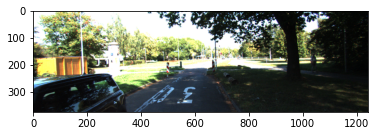

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
# 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

# 바운딩 박스를 시각화
visualized_image=visualize_bbox(img, objects['bbox'].numpy())

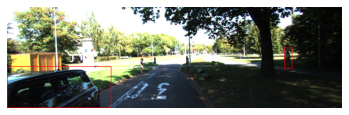

In [7]:
# 결과 출력
plt.imshow(visualized_image)
plt.axis("off")
plt.show()

##  17-4. RetinaNet

- [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)

RetinaNet은 **Focal Loss for Dense Object Detection** 논문을 통해 공개된 detection 모델입니다.

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었습니다. 이를 해결하기 위해서 RetinaNet에서는 **focal loss**와 **FPN(Feature Pyramid Network)** 를 적용한 네트워크를 사용합니다.

### Focal Loss

---

> 물체를 배경보다 더 잘 학습하자 == 물체인 경우 Loss를 작게 만들자

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-car.max-800x600.png)[https://www.jeremyjordan.me/object-detection-one-stage/](https://www.jeremyjordan.me/object-detection-one-stage/)

Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다. 여기서 그리드(grid)와 픽셀(pixel)이 혼란스러울 수 있겠는데, 위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field입니다.

그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 됩니다. 논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였습니다.

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/focal_loss.png)[https://arxiv.org/abs/1708.02002](https://arxiv.org/abs/1708.02002)

Focal loss는 우리가 많이 사용해왔던 교차 엔트로피를 기반으로 만들어졌습니다. 위 그림을 보면 Focal loss는 그저 교차 엔트로피 CE(ptpt​)의 앞단에 간단히 (1−pt)γ(1−pt​)γ 라는 modulating factor를 붙여주었습니다.

교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단되므로 손실이 줄어드는 것을 볼 수 있습니다. 하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어지는데요.

이 상황은 물체 검출 모델을 학습시키는 과정에서 문제가 될 수 있습니다. 대부분의 이미지에서는 물체보다 배경이 많습니다. 따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있습니다. 이렇게 너무 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해줍니다.γγ를 0으로 설정하면 modulating factor (1−pt)γ(1−pt​)γ가 1이 되어 일반적인 교차 엔트로피가 되고 γγ가 커질수록 modulating이 강하게 적용되는 것을 확인할 수 있습니다.

### FPN(Feature Pyramid Network)

---

> 여러 층의 특성 맵(feature map)을 다 사용해보자

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-fpn.max-800x600.png)[https://arxiv.org/abs/1612.03144](https://arxiv.org/abs/1612.03144)

FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식입니다. CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있습니다. 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있습니다. 이를 **receptive field**라고 합니다. 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 되는 것입니다.

FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있습니다. SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용했습니다. 레이어가 깊어질수록 feature map의 ww, hh방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적인 거죠.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-FPN.max-800x600.png)[https://arxiv.org/abs/1708.02002](https://arxiv.org/abs/1708.02002)

위 그림은 RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지를 설명하는 그림입니다. RetinaNet에서는 FPN을 통해 P3P3​부터 P7P7​까지의 pyramid level을 생성해 사용합니다. 각 pyramid level은 256개의 채널로 이루어지게 됩니다. 이를 통해 **Classification Subnet**과 **Box Regression Subnet** 2개의 Subnet을 구성하게 되는데, Anchor 갯수를 AA라고 하면 최종적으로 Classification Subnet은 K개 class에 대해 KA개 채널을, Box Regression Subnet은 4A개 채널을 사용하게 됩니다.

## 17-5. 데이터 준비

데이터 파이프 라인

먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸어 주어야 합니다. 이때 사용할 데이터 파이프라인을 구축합니다.

데이터 파이프라인은 총 4단계로 이루어집니다.
- x와 y좌표 위치 교체
- 무작위로 수평 뒤집기(Flip)
- 이미지 크기 조정 및 패딩 추가
- 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

독립적인 함수를 각각 작성합니다

In [8]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


In [9]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5: #기존 0.5
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


이미지 크기를 바꿀 때는 고려할 점이 있습니다. 이미지의 비율은 그대로 유지되어야 하고, 
이미지의 최대/최소 크기도 제한해야 하거든요. 또 이미지의 크기를 바꾼 후에도 최종적으로 
모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들 거예요.

예를 들어 600x720 크기의 이미지가 있다면 800x960 크기로 바꿀 수 있습니다. 
여기에 stride를 128로 놓아 800x960 크기의 이미지에 패딩을 더해 896x1024 크기의 
이미지로 모델에 입력하겠다는 이야깁니다. 모델에 입력되는 이미지에는 검정 테두리가 있겠군요!

실제로 입력할 이미지를 어떻게 바꿀지는 min_side, max_side, min_side_range, stride등에 의해 결정돼요. 
그리고 학습이 완료된 모델을 사용할 때는 입력할 이미지를 다양한 크기로 바꿀 필요는 없으니 분기처리를 해줍니다.

In [10]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


In [11]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


In [12]:
# 준비된 함수들을 연결

def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


### 인코딩
---
One stage detector에서는 Anchor Box라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정됩니다. 

그래서 기본적으로 Anchor Box를 생성해줘야 합니다. Anchor Box로 생성되는 것은 물체 위치 후보라고 생각하면 됩니다. 

물체 위치를 주관식이 아닌 객관식으로 풀게 하는 겁니다.

예를 들어 100개의 Anchor Box를 생성했다고 가정하면 이미 만들어진 100개의 Anchor Box에 해당하지 않는 위치, 크기, 비율에 물체가 있을 수 없습니다. 100개의 Anchor Box중 가장 근접한 하나가 선택이 되겠죠. 이렇게 선택된 Anchor Box를 기초로 정확한 위치를 찾아냅니다. 추가로 Anchor Box로부터 상하좌우로 떨어진 정도, 가로 세로의 크기 차이를 미세하게 찾아내죠. 게다가 Anchor Box가 촘촘하게 겹치도록 생성되기 때문에 물체를 잘 찾아낼 수 있습니다.

또, RetinaNet에서는 FPN을 사용하기 때문에 Anchor Box가 더 많이 필요합니다. FPN의 각 층마다 Anchor Box가 필요하기 때문입니다. RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어 있기 때문에 각 level에서 만들어지는 Anchor Box도 약속되어 있습니다.

여기서는 논문과 같은 형태로 Anchor Box를 생성합니다.

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-4-1.png)[https://arxiv.org/pdf/1708.02002.pdf](https://arxiv.org/pdf/1708.02002.pdf)

In [13]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


In [14]:
# Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형
# IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크
# IoU를 계산할 수 있는 함수 만듬

def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


이제 실제 라벨을 Anchor Box에 맞춰주는 클래스를 만들어 봅시다. 위에서 작성한 `compute_iou` 함수를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해 줍니다. 그리고 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산합니다. 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록해 둡니다.

> 이 과정에서 `variance`가 등장하는데 관례적으로 Anchor Box를 사용할 때 등장합니다.  
> 어디에도 정확한 이유가 등장하지는 않지만 상하좌우의 차이에는 0.1, 가로세로 크기의 차이에는 0.2를 사용합니다.  
> 이와 관련하여 통계적 추정치를 계산할 때 분산으로 나눠주는 것 때문이라는 의견이 있습니다.

이 과정은 마치 데이터를 훈련이 가능한 형식으로 encode하는 것 같으니 LabelEncoder라는 이름으로 클래스를 만들었습니다.

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-4-2.png)

[IoU가 0.5보다 높으면 물체, 0.4보다 낮으면 배경입니다]

[https://arxiv.org/pdf/1708.02002.pdf](https://arxiv.org/pdf/1708.02002.pdf)

In [15]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


## 17-6. 모델 작성

### Feature Pyramid
---
앞서 설명했듯이 RetinaNet에서는 FPN(Feature Pyramid Network)를 사용합니다. 완전히 동일한 것은 아니고 약간 수정해서 사용했습니다. 

자세한 설명은 아래에 나와있네요.

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-5-1.png)

[FPN을 약간 수정합니다]

[https://arxiv.org/pdf/1708.02002.pdf](https://arxiv.org/pdf/1708.02002.pdf)

In [16]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요합니다. 그것을 head라고 부르기도 합니다. 

Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 class를 예상하고, box도 예상합니다. 

class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 둘 다 틀릴 수도 있겠죠? 

class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 것이 중요합니다.

그래서 각각의 head를 만들어 줍니다. head부분은 유사한 형태로 만들 수 있으니 

build_head라는 함수를 하나만 만들고 두 번 호출하면 될 것 같네요.






In [17]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


우리가 만들 RetinaNet의 backbone은 ResNet50입니다. 

FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해 줍니다

In [18]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


이제 RetinaNet을 완성해 봅시다. Backbone + FPN + classification용 head + box용 head 입니다.

In [19]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3



이제 모델을 준비했고, Loss에 대한 준비를 해봅시다.

RetinaNet에서는 Focal Loss를 사용하는데요. Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용됩니다.

Box Regression에는 Smooth L1 Loss를 사용했네요.

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-5-2.png)

[Focal Loss + Smooth L1 Loss]

[https://arxiv.org/pdf/1708.02002.pdf](https://arxiv.org/pdf/1708.02002.pdf)

Smooth L1 Loss을 사용하는 Box Regression에는 `delta`를 기준으로 계산이 달라지고, 

Focal Loss를 사용하는 Classification에서는 `alpha`와 `gamma`를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의하세요!

In [20]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


In [21]:
# 앞에서 만들어 놓은 클래스와 함수를 이용해서 모델을 조립하고 학습시켜 봅시다.


num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

슝=3


In [22]:
# Optimizer는 동일하게 SGD를 사용합니다.
# 논문에서는 8개의 GPU를 사용했기 때문에 우리 환경과는 맞지 않음
# Learning Rate 수정

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [23]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=16, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('데이터셋 준비 완료')

데이터셋 준비 완료


In [24]:
# # 학습된 모델을 불러오기

# model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
# old_checkpoint = tf.train.latest_checkpoint(model_dir)
# model.load_weights(latest_checkpoint)

# print(f"저장된 최적 모델 가중치 로드 완료: {latest_checkpoint}")

In [25]:
# !rm my_large_log_file.log

In [85]:
import os

# 디렉토리 경로 설정
best_weights_path = '/aiffel/aiffel/object_detection/checkpoints/'

# 디렉토리 내용 보기
try:
    if os.path.exists(best_weights_path) and os.path.isdir(best_weights_path):
        files = os.listdir(best_weights_path)
        if files:
            print(f"'{best_weights_path}' 디렉토리의 내용:")
            for file in files:
                print(f"- {file}")
        else:
            print(f"'{best_weights_path}' 디렉토리가 비어 있습니다.")
    else:
        print(f"'{best_weights_path}' 경로가 존재하지 않거나 디렉토리가 아닙니다.")
except Exception as e:
    print(f"디렉토리 내용을 확인하는 중 오류가 발생했습니다: {e}")


'/aiffel/aiffel/object_detection/checkpoints/' 디렉토리의 내용:
- weights_epoch1.data-00000-of-00001
- weights_epoch6.index
- best_weights_epoch3.data-00000-of-00001
- weights_epoch_1.data-00000-of-00001
- weights_epoch6.data-00000-of-00001
- weights_epoch7.index
- best_weights_epoch7.index
- weights_epoch7.data-00000-of-00001
- best_weights_epoch8.data-00000-of-00001
- weights_epoch3.index
- weights_epoch1.index
- best_weights_epoch1.data-00000-of-00001
- checkpoint
- weights_epoch5.data-00000-of-00001
- weights_epoch4.index
- best_weights_epoch5.data-00000-of-00001
- weights_epoch2.index
- weights_epoch5.index
- best_weights_epoch8.index
- best_weights_epoch5.index
- best_weights_epoch2.data-00000-of-00001
- weights_epoch2.data-00000-of-00001
- weights_epoch4.data-00000-of-00001
- weights_epoch_1.index
- best_val_loss.json
- weights_epoch9.index
- training_history.json
- best_weights_epoch1.index
- weights_epoch8.index
- best_weights_epoch7.data-00000-of-00001
- weights_epoch3.data-00000-of

In [84]:
best_weights_path = os.path.join(new_model_dir, "best_weights_epoch8.h5")

if os.path.exists(best_weights_path):
    checkpoint.restore(best_weights_path).expect_partial()
    print(f"최적 모델 가중치 복원 완료: {best_weights_path}")
else:
    print("최적 모델 가중치를 찾을 수 없음. 새 모델로 시작합니다.")

최적 모델 가중치를 찾을 수 없음. 새 모델로 시작합니다.


In [86]:
import os
import tensorflow as tf
import json
import shutil
from tqdm import tqdm  # 진행률 표시를 위한 라이브러리

# 기존 가중치가 저장된 경로
initial_model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'

# 새로운 저장 경로 설정
new_model_dir = os.getenv('HOME') + '/aiffel/object_detection/checkpoints/'
os.makedirs(new_model_dir, exist_ok=True)


# 최적 모델 가중치 파일 경로
best_weights_path = os.path.join(new_model_dir, "best_weights_epoch.h5")


# # 기존 가중치를 새로운 경로로 복사
# for file_name in os.listdir(initial_model_dir):
#     source_path = os.path.join(initial_model_dir, file_name)
#     destination_path = os.path.join(new_model_dir, file_name)
#     if os.path.isfile(source_path):
#         shutil.copy(source_path, destination_path)
# print(f"기존 가중치가 {new_model_dir}로 복사되었습니다.")

# 최적 검증 손실 파일 경로
best_val_loss_file = os.path.join(new_model_dir, "best_val_loss.json")
latest_checkpoint = tf.train.latest_checkpoint(new_model_dir)

# 최적의 검증 손실 값 초기화
if os.path.exists(best_val_loss_file):
    with open(best_val_loss_file, "r") as f:
        best_val_loss_data = json.load(f)
    best_val_loss = best_val_loss_data.get("best_val_loss", float("inf"))
    print(f"저장된 최적 검증 손실 값 로드: {best_val_loss:.4f}")
else:
    best_val_loss = float("inf")
    print("최적 검증 손실 값이 존재하지 않음. 새로 초기화합니다.")

 # 옵티마이저 및 컴파일 설정
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
   
    
    
# 모델 초기화 및 가중치 로드
num_classes = 8
batch_size = 16

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(new_model_dir)

# best_weights_pattern = os.path.join(new_model_dir, "best_weights_epoch*.h5")
# best_weights_files = glob.glob(best_weights_pattern)

# 디렉토리와 파일 경로 설정
best_weights_path = '/aiffel/aiffel/object_detection/checkpoints/best_weights_epoch8'

# 가중치 로드 및 모델 복원
try:
    if os.path.exists(best_weights_path + '.index'):
        model.load_weights(best_weights_path).expect_partial()
        print(f"최적 가중치 '{best_weights_path}' 로드 완료.")
    else:
        print(f"가중치 파일이 존재하지 않습니다: {best_weights_path}")
except Exception as e:
    print(f"가중치 로드 중 오류가 발생했습니다: {e}")

# if latest_checkpoint:
#     checkpoint.restore(latest_checkpoint).expect_partial()
#     print(f"체크포인트 복원 완료: {latest_checkpoint}")
# else:
#     print("저장된 체크포인트를 찾을 수 없음. 새 모델로 시작합니다.")
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)
model.compile(loss=loss_fn, optimizer=optimizer)

# 학습 결과 저장용 변수
history = {"batch_loss": [], "batch_accuracy": [], "epoch_val_loss": []}

# 사용자 정의 학습 루프
@tf.function
def train_step(model, images, labels, optimizer, loss_fn):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss_value = loss_fn(labels, predictions)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value

# 학습 설정
epochs = 4

# 배치 단위 학습
print('학습 시작')
for epoch in range(epochs):
    print(f"\n===== 에폭 {epoch + 1}/{epochs} =====")
    epoch_loss = 0
    batch_count = 0

    # tqdm을 사용하여 배치 진행률 및 ETA 표시
    progress_bar = tqdm(enumerate(train_dataset), total=len(train_dataset), desc=f"에폭 {epoch + 1}")
    for batch, (images, labels) in progress_bar:
        loss_value = train_step(model, images, labels, optimizer, loss_fn)
        epoch_loss += loss_value
        batch_count += 1

        # tqdm에 손실 값 표시
        progress_bar.set_postfix({"손실": loss_value.numpy()})

    epoch_loss /= batch_count
    
    # 에폭이 끝난 뒤 한 번만 저장
    save_path_new = os.path.join(new_model_dir, f"weights_epoch{epoch + 1}")
    model.save_weights(save_path_new)
    
    # 검증 단계    
    val_loss = model.evaluate(val_dataset, verbose=0)
    history["epoch_val_loss"].append(val_loss)
    model.compile(loss=loss_fn, optimizer=optimizer)

    print(f"[에폭 종료] 에폭 {epoch + 1}, 평균 손실: {epoch_loss:.4f}, 검증 손실: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_save_path = os.path.join(new_model_dir, f"best_weights_epoch{epoch + 1}")
        model.save_weights(best_save_path)
        print(f"검증 손실 개선: {best_val_loss:.4f}, 최적 가중치 저장 완료: {best_save_path}")
        

        with open(best_val_loss_file, "w") as f:
            json.dump({"best_val_loss": best_val_loss}, f)

print('학습 완료')

history_file = os.path.join(new_model_dir, "training_history.json")
with open(history_file, "w") as f:
    json.dump(history, f)
print(f"학습 기록 저장 완료: {history_file}")


저장된 최적 검증 손실 값 로드: 0.9506
최적 가중치 '/aiffel/aiffel/object_detection/checkpoints/best_weights_epoch8' 로드 완료.
학습 시작

===== 에폭 1/4 =====


에폭 1: 100%|██████████| 3173/3173 [25:46<00:00,  2.05it/s, 손실=1.79] 


[에폭 종료] 에폭 1, 평균 손실: 2.1982, 검증 손실: 1.6193

===== 에폭 2/4 =====


에폭 2: 100%|██████████| 3173/3173 [25:44<00:00,  2.05it/s, 손실=0.969] 


[에폭 종료] 에폭 2, 평균 손실: 0.9887, 검증 손실: 1.1529

===== 에폭 3/4 =====


에폭 3: 100%|██████████| 3173/3173 [26:30<00:00,  1.99it/s, 손실=0.604] 


[에폭 종료] 에폭 3, 평균 손실: 0.7162, 검증 손실: 1.0800

===== 에폭 4/4 =====


에폭 4: 100%|██████████| 3173/3173 [25:40<00:00,  2.06it/s, 손실=0.34]  


[에폭 종료] 에폭 4, 평균 손실: 0.5713, 검증 손실: 1.1149
학습 완료
학습 기록 저장 완료: /aiffel/aiffel/object_detection/checkpoints/training_history.json


In [90]:
# 가중치 로드 및 모델 복원
try:
    if os.path.exists(best_weights_path + '.index'):
        model.load_weights(best_weights_path).expect_partial()
        print(f"최적 가중치 '{best_weights_path}' 로드 완료.")
    else:
        print(f"가중치 파일이 존재하지 않습니다: {best_weights_path}")
except Exception as e:
    print(f"가중치 로드 중 오류가 발생했습니다: {e}")

최적 가중치 '/aiffel/aiffel/object_detection/checkpoints/best_weights_epoch8' 로드 완료.


In [91]:
# 검증 단계    
val_loss = model.evaluate(val_dataset, verbose=0)
history["epoch_val_loss"].append(val_loss)
model.compile(loss=loss_fn, optimizer=optimizer)

print(f"[에폭 종료] 에폭 {epoch + 1}, 평균 손실: {epoch_loss:.4f}, 검증 손실: {val_loss:.4f}")

if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_save_path = os.path.join(new_model_dir, f"best_weights_epoch{epoch + 1}")
    model.save_weights(best_save_path)
    print(f"검증 손실 개선: {best_val_loss:.4f}, 최적 가중치 저장 완료: {best_save_path}")


    with open(best_val_loss_file, "w") as f:
        json.dump({"best_val_loss": best_val_loss}, f)

[에폭 종료] 에폭 4, 평균 손실: 0.5713, 검증 손실: 0.9557


In [30]:

def load_training_history(file_path):
    """
    학습 히스토리를 JSON 파일에서 불러옵니다.
    """
    with open(file_path, "r") as f:
        history = json.load(f)
    return history
# 학습 히스토리 로드
history = load_training_history(history_file)


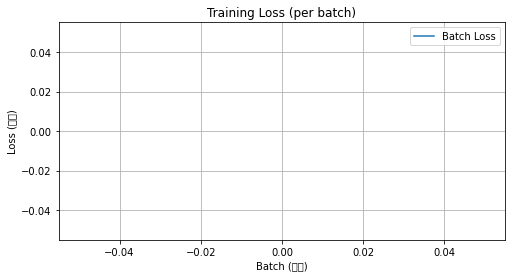

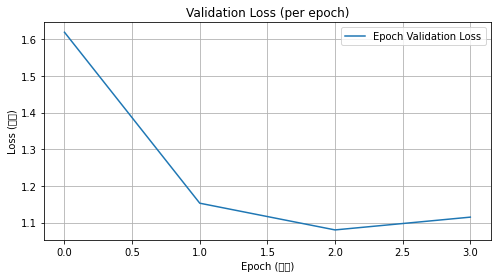

In [87]:
import json
import matplotlib.pyplot as plt



def visualize_training_history(history):
    """
    학습 히스토리를 시각화합니다.
    - 배치 단위 손실
    - 배치 단위 정확도
    - 에폭 단위 검증 손실
    """
    # 배치 단위 손실
    plt.figure(figsize=(8, 4))
    plt.plot(history["batch_loss"], label="Batch Loss")
    plt.title("Training Loss (per batch)")  # 영어 제목
    plt.xlabel("Batch (배치)")
    plt.ylabel("Loss (손실)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 배치 단위 정확도 (옵션: history에 batch_accuracy가 있을 때만)
    if "batch_accuracy" in history and len(history["batch_accuracy"]) > 0:
        plt.figure(figsize=(8, 4))
        plt.plot(history["batch_accuracy"], label="Batch Accuracy")
        plt.title("Training Accuracy (per batch)")  # 영어 제목
        plt.xlabel("Batch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

    # 에폭 단위 검증 손실
    plt.figure(figsize=(8, 4))
    plt.plot(history["epoch_val_loss"], label="Epoch Validation Loss")
    plt.title("Validation Loss (per epoch)")  # 영어 제목
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# 시각화
visualize_training_history(history)



In [30]:
# #학습예시

# model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
# callbacks_list = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
#         monitor="loss",
#         save_best_only=False,
#         save_weights_only=True,
#         verbose=1,
#     )
# ]

# epochs = 2

# model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     callbacks=callbacks_list
# )

Epoch 1/2


3173/3173 [==============================] - 1630s 508ms/step - loss: 0.7229 - val_loss: 1.1114

Epoch 00001: saving model to /aiffel/aiffel/object_detection/data/checkpoints/weights_epoch_1


PermissionDeniedError: /aiffel/aiffel/object_detection/data/checkpoints/weights_epoch_1_temp; Read-only file system [Op:SaveV2]

## 17-8. 결과 확인하기

In [83]:
# # 학습된 모델을 불러오기

# model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
# latest_checkpoint = tf.train.latest_checkpoint(model_dir)
# model.load_weights(latest_checkpoint)

# print('슝=3')

슝=3


In [141]:
# 가중치 로드 및 모델 복원(8에서 최저)
try:
    if os.path.exists(best_weights_path + '.index'):
        model.load_weights(best_weights_path).expect_partial()
        print(f"최적 가중치 '{best_weights_path}' 로드 완료.")
    else:
        print(f"가중치 파일이 존재하지 않습니다: {best_weights_path}")
except Exception as e:
    print(f"가중치 로드 중 오류가 발생했습니다: {e}")

최적 가중치 '/aiffel/aiffel/object_detection/checkpoints/best_weights_epoch8' 로드 완료.


모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어 줍니다. 

논문에서는 1000개의 후보를 골라 처리했지만 우리는 100개의 후보만 골라 처리하도록 합시다. 나머지 설정은 논문과 동일하게 해볼게요.

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-7-1.png)

[0.05보다 높은 box 1000개를 골라 0.5 NMS를 진행합니다]

[https://arxiv.org/pdf/1708.02002.pdf](https://arxiv.org/pdf/1708.02002.pdf)

NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 `tf.image.combined_non_max_suppression`를 사용했습니다.

- [tf.image.combined_non_max_suppression](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

위 참고자료를 꼭 읽어보세요. 입출력되는 값이 어떤지 알아야 코드가 이해가 됩니다. 특히 출력에 

`nmsed_boxes`, `nmsed_scores`, `nmsed_classes`, `valid_detections`이 각각 무엇인지 알아야 활용할 수 있습니다.

In [156]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


In [143]:
# test image 추가

img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'


image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


In [157]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


In [158]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


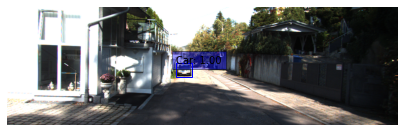

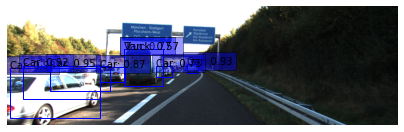

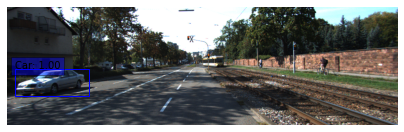

In [146]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(3):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

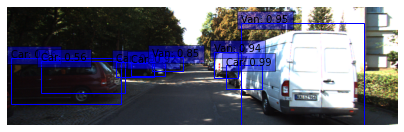

<AxesSubplot:>

In [147]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 경로 설정
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/stop_4.png'

# # 모델 입력 이미지 전처리 함수 정의
# def prepare_image(image):
#     """
#     모델 입력에 맞게 이미지를 전처리합니다.
#     - 이미지를 224x224로 리사이즈하고 배치 차원을 추가합니다.
#     """
#     input_image = tf.image.resize(image, (224, 224))  # 모델 입력 크기에 맞게 리사이즈
#     input_image = input_image / 255.0  # 정규화
#     input_image = tf.expand_dims(input_image, axis=0)  # 배치 차원 추가
#     original_size = tf.shape(image)[:2]
#     original_size = tf.cast(original_size, dtype=tf.float32)  # float32로 변환
#     ratio = original_size[0] / 224.0  # 리사이즈 비율
#     return input_image, ratio



# 새 이미지 로드 및 전처리
image = tf.io.read_file(img_path)  # 이미지 파일 읽기
image = tf.image.decode_png(image, channels=3)  # PNG 이미지 디코딩
image = tf.cast(image, dtype=tf.float32)  # float32로 변환
input_image, ratio = prepare_image(image)  # 이미지 전처리

# 클래스 이름 변환을 위한 int2str (KITTI 데이터셋 정보 활용)
dataset_info = tfds.builder("kitti", data_dir=DATA_PATH).info
int2str = dataset_info.features["objects"]["type"].int2str

# 모델 예측 (inference_model이 미리 정의되어 있어야 함)
detections = inference_model.predict(input_image)

# 예측된 결과 시각화
num_detections = int(detections.valid_detections[0])
class_names = [
    int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
]
visualize_detections(
    image.numpy().astype(np.uint8),  # PIL 이미지로 변환
    detections.nmsed_boxes[0][:num_detections] / ratio,  # 좌표 복원
    class_names,
    detections.nmsed_scores[0][:num_detections],
)


In [148]:
# 모델 예측
detections = inference_model.predict(input_image)

# 예측 결과 확인
print("Valid Detections:", detections.valid_detections[0])
print("NMSed Boxes:", detections.nmsed_boxes[0])
print("NMSed Classes:", detections.nmsed_classes[0])
print("NMSed Scores:", detections.nmsed_scores[0])


Valid Detections: 8
NMSed Boxes: [[ 744.9456     122.318924   869.96075    203.4091   ]
 [ 372.37067    163.78867    499.8824     214.73819  ]
 [  13.444122    70.597824   388.80234    228.41347  ]
 [ 798.99194     -4.6966705 1217.5319     348.3567   ]
 [ 703.697      159.72493    787.83704    249.75438  ]
 [ 421.45853    167.2622     539.48706    212.46371  ]
 [ 495.24838    183.82896    600.67725    232.11986  ]
 [ 115.22125    109.8535     400.7885     219.28645  ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0.           0.       ]
 [   0.           0.           0

In [149]:
print("Class Names:", class_names)
print("Scores:", detections.nmsed_scores[0][:num_detections])

Class Names: ['Car', 'Car', 'Car', 'Van', 'Van', 'Car', 'Van', 'Car']
Scores: [0.99293435 0.9711917  0.9559164  0.9522774  0.9351079  0.9233737
 0.85008955 0.5551269 ]


In [150]:
"""
[Title: Self-Driving Assistance Function]
(Footnote: Checks if there is at least one person or if any vehicle's bounding box is ≥ 300px in width/height.)
"""
import tensorflow as tf
import os
import numpy as np


def self_drive_assist(img_path, size_limit=300):
    """
    사람이 한 명 이상 있는 경우 혹은 차량의 크기(width 또는 height)가 size_limit(기본 300px) 이상인 경우 "Stop",
    그렇지 않다면 "Go"를 반환합니다.
    """
    # 이미지 로드 및 전처리
    image = tf.io.read_file(img_path)         # 이미지 파일 읽기
    image = tf.image.decode_png(image, channels=3)  # PNG 이미지 디코딩
    image = tf.cast(image, dtype=tf.float32)        # float32로 변환
    input_image, ratio = prepare_image(image)       # 이미지 전처리(리사이즈, 정규화, 배치 차원 추가)

    # 모델 추론(inference)
    detections = inference_model.predict(input_image)  # 이미 사전에 정의되어 있어야 함
    num_detections = int(detections.valid_detections[0])

    # 클래스 인덱스를 실제 문자열로 변환 (KITTI 데이터셋 기준)
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    
    # 좌표 복원 (모델 추론 시 224x224에 맞춰진 것을 원본 비율로 복원)
    # nmsed_boxes: [ymin, xmin, ymax, xmax]
    restored_boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    
    # 정지 조건:
    # 1) 사람이 한 명 이상 있는 경우 (예: "Pedestrian" 또는 "Person_sitting" 등으로 가정)
    # 2) 차량(Car 등)의 크기(width 또는 height)가 size_limit 이상인 경우
    person_keywords = ["Pedestrian", "Person", "Person_sitting"]
    vehicle_keywords = ["Car", "Van", "Truck", "Tram"]  # 실제 사용 시 원하는 차량 클래스 추가 가능

    # 탐지 결과 확인
    for i, cls in enumerate(class_names):
        # 박스 좌표
        ymin, xmin, ymax, xmax = restored_boxes[i]
        box_width = xmax - xmin
        box_height = ymax - ymin
        
        # 1) 사람이 한 명 이상 있는 경우
        if any(pk in cls for pk in person_keywords):
            return "Stop"

        # 2) 차량 크기 판별(차량 클래스라면 가로/세로 길이를 확인)
        if any(vk in cls for vk in vehicle_keywords):
            if box_width >= size_limit or box_height >= size_limit:
                return "Stop"

    # 모든 정지 조건을 만족하지 않았다면 "Go"
    return "Go"


# 평가 코드
def test_system(func):
    work_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
    score = 0
    test_set = [
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")



In [161]:
# 테스트 실행 예시:
test_system(self_drive_assist)

100점입니다.


In [127]:
def test_system_with_display(func):
    """
    10장 이미지를 각각 출력하고, 예측 결과와 실제 정답을 함께 표시합니다.
    모든 테스트를 마친 후 최종 점수를 출력합니다.
    """
    work_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
    score = 0
    test_set = [
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    # 서브플롯: 2행 5열(총 10개)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    axes = axes.flatten()  # 2D 배열 -> 1D 리스트로 변환

    for i, (image_file, answer) in enumerate(test_set):
        image_path = os.path.join(work_dir, image_file)
        pred = func(image_path)
        
        # 점수 계산
        if pred == answer:
            score += 10
        
        # 이미지 로드 (시각화를 위해)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        
        # Matplotlib 출력
        axes[i].imshow(image.numpy().astype("uint8"))
        axes[i].axis("off")  # 축 표시 제거
        axes[i].set_title(f"Pred: {pred}, Ans: {answer}", fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"{score}점입니다.")



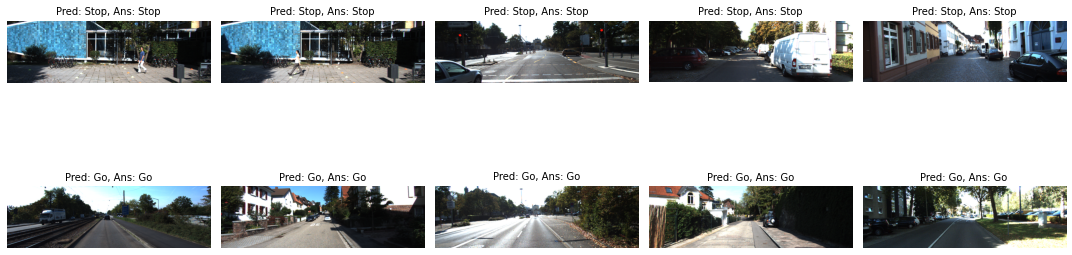

100점입니다.


In [128]:

# 사용 예시:
test_system_with_display(self_drive_assist)

In [162]:
# -*- coding: utf-8 -*-
"""
[Title: Self-Driving Assistance with Bounding Box Display and Final Score]
(Footnote: Shows bounding boxes, model detections, and 'Stop/Go' decision for each image, then prints the total score.)

[주의 사항]
- 'prepare_image', 'inference_model', 'int2str' 함수/변수들이 사전에 정의되어 있어야 합니다.
- 'self_drive_assist' 함수는 사람이 한 명 이상 있거나, 차량의 크기가 일정 픽셀 수 이상이면 "Stop"을 반환하고,
  그렇지 않으면 "Go"를 반환해야 합니다.
- 아래 코드는 10장의 테스트 이미지를 대상으로 각 이미지별로 예측 결과를 시각화하고,
  콘솔에는 바운딩 박스 정보와 최종 점수를 표시합니다.
- 'visualize_detections' 함수는 이미 정의되어 있으며, [x1, y1, x2, y2] 형태와 Matplotlib 좌표계를 고려해
  내부적으로 y축을 뒤집어서(Rectangle과 text 기준) 시각화합니다.
"""

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##############################
#  이미 정의된 시각화 함수  #
##############################
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """
    시각화를 위한 함수 (사전에 주어진 코드).
    - image: (H, W, 3) 형태의 원본 이미지를 넘파이 uint8로 변환한 것
    - boxes: 각 오브젝트마다 [x1, y1, x2, y2] (왼쪽 위 원점 체계 기준)
    - classes: 클래스 이름 목록
    - scores: 신뢰도(Confidence) 목록
    - figsize, linewidth, color: Matplotlib 시각화 설정
    """
    # 이미지를 numpy 배열(uint8)로 캐스팅
    image = np.array(image, dtype=np.uint8)
    
    # 그림 크기 설정 및 축 제거
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()

    # 박스, 클래스, 스코어를 하나씩 꺼내서 시각화
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        
        # box는 [x1, y1, x2, y2] 형태라고 가정
        x1, y1, x2, y2 = box
        
        # Matplotlib에서 Rectangle의 (x, y)는 좌하단 기준이므로
        # 원본 이미지 좌표계(왼쪽 위가 (0,0))를 아래로 뒤집어줌
        origin_x, origin_y = x1, image.shape[0] - y2
        
        # 사각형 폭/높이
        w, h = (x2 - x1), (y2 - y1)
        
        # 박스 테두리(Rectangle) 그리기
        patch = plt.Rectangle(
            [origin_x, origin_y],
            w,
            h,
            fill=False,
            edgecolor=color,
            linewidth=linewidth
        )
        ax.add_patch(patch)
        
        # 박스 왼쪽 하단에 클래스명 및 스코어 표시
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

# #########################################################
# #  prepare_image 함수 예시 (가로·세로 비율 따로 계산)  #
# #########################################################

def prepare_image2(image, resize_shape=(224, 224)):
    """이미지 전처리 함수
    - resize_shape: (H, W) 형태의 타겟 크기
    """
    original_size = tf.shape(image)[:2]  # 원본 이미지 크기 (H, W)
    original_size = tf.cast(original_size, tf.float32)  # float으로 변환
    
    # 세로/가로 비율 계산
    ratio_h = original_size[0] / resize_shape[0]  # 세로축 비율
    ratio_w = original_size[1] / resize_shape[1]  # 가로축 비율
    
    # 이미지 리사이즈 및 정규화
    resized_image = tf.image.resize(image, resize_shape)
    resized_image = resized_image / 255.0  # 정규화
    
    # 배치 차원 추가
    input_image = tf.expand_dims(resized_image, axis=0)
    
    return input_image, ratio_h, ratio_w




# def prepare_image(image, resize_shape=(224, 224)):
#     original_size = tf.shape(image)[:2]
#     original_size = tf.cast(original_size, tf.float32)
#     ratio = original_size[0] / resize_shape[0]  # 세로축 기준으로만 사용 (예시)

#     resized_image = tf.image.resize(image, resize_shape)
#     resized_image = resized_image / 255.0
#     input_image = tf.expand_dims(resized_image, axis=0)

#     return input_image, ratio

#########################################################
#  테스트 시스템: 각 이미지에 대해 박스·결과·최종 점수 표시
#########################################################
def test_system_with_display_and_bboxes(self_drive_func, size_limit=300):
    """
    - 10장의 테스트 이미지를 불러와서 self_drive_func(Stop/Go 판단)을 실행
    - inference_model.predict(...)로부터 바운딩 박스를 추론받아
      visualize_detections 함수를 통해 시각적으로 표시
    - 콘솔에는 각 객체의 클래스명, 박스 크기 등을 출력
    - 최종적으로는 누적 점수를 출력
    """
    # 테스트 이미지가 위치한 디렉터리 설정
    work_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
    
    # 점수 누적 변수
    score = 0
    
    # 테스트 이미지와 정답 레이블 설정
    test_set = [
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    # 각 이미지에 대해 반복
    for image_file, answer in test_set:
        # 이미지 경로
        image_path = os.path.join(work_dir, image_file)
        
        #------------------------------------------------------#
        # 1) Self-driving 보조 함수(self_drive_func)를 이용한 예측
        #------------------------------------------------------#
        pred_label = self_drive_func(image_path, size_limit=size_limit)
        
        # 예측 결과가 정답과 같다면 10점 가산
        if pred_label == answer:
            score += 10
        
        #------------------------------------------------------#
        # 2) 박스 시각화를 위해 원본 이미지를 로드
        #------------------------------------------------------#
        raw_image = tf.io.read_file(image_path)
        raw_image = tf.image.decode_png(raw_image, channels=3)
        raw_image = tf.cast(raw_image, dtype=tf.float32)
        
        # prepare_image 호출 시, 가로/세로 비율을 따로 반환받음
        input_image, ratio_h, ratio_w = prepare_image2(raw_image, (224, 224))
        
        # 사전에 정의된 inference_model로 예측
        detections = inference_model.predict(input_image)
        num_detections = int(detections.valid_detections[0])
        
        # 클래스 인덱스, 박스, 스코어 정보 가져오기
        class_indices = detections.nmsed_classes[0][:num_detections]
        boxes = detections.nmsed_boxes[0][:num_detections]       # [ymin, xmin, ymax, xmax]
        scores_detected = detections.nmsed_scores[0][:num_detections]
        
        #------------------------------------------------------#
        # 3) [ymin, xmin, ymax, xmax] -> [x1, y1, x2, y2] 변환 후
        #    (ratio_h, ratio_w)로 원본 좌표계를 복원
        #------------------------------------------------------#
        restored_boxes = []
        for box in boxes:
            ymin, xmin, ymax, xmax = box
            
            # 세로는 ratio_h, 가로는 ratio_w 사용
            y1 = ymin * ratio_h
            x1 = xmin * ratio_w
            y2 = ymax * ratio_h
            x2 = xmax * ratio_w
            
            # [x1, y1, x2, y2] 형태
            restored_boxes.append([x1, y1, x2, y2])
        
        # 클래스 인덱스를 실제 문자열로 변환
        class_names = [int2str(int(idx)) for idx in class_indices]
        
        #------------------------------------------------------#
        # 4) 콘솔에 정보 출력 (박스 크기, 클래스, 스코어 등)
        #------------------------------------------------------#
        print(f"[이미지: {image_file}] => 예측값: {pred_label}, 정답: {answer}")
        for i in range(num_detections):
            cls_name = class_names[i]
            x1, y1, x2, y2 = restored_boxes[i]
            conf_val = float(scores_detected[i])
            
            # 폭과 높이 계산
            box_width = x2 - x1
            box_height = y2 - y1
            
            print(
                f"  감지된 객체 {i+1}: {cls_name} "
                f"(confidence: {conf_val:.2f}), "
                f"박스 크기: (w={box_width:.1f}, h={box_height:.1f})"
            )
        print("-" * 60)
        
        #------------------------------------------------------#
        # 5) 시각화 함수(visualize_detections) 호출
        #    각 이미지마다 별도 창(figure)로 표시됨
        #------------------------------------------------------#
        print(f"※ {image_file} 시각화 창을 띄웁니다...")
        visualize_detections(
            raw_image.numpy().astype("uint8"),  # 원본 이미지 (uint8)
            restored_boxes,                    # [x1, y1, x2, y2] 형식
            class_names,
            scores_detected
        )
    
    #------------------------------------------------------#
    # 6) 모든 이미지 처리가 끝난 후 최종 점수 출력
    #------------------------------------------------------#
    print(f"최종 점수: {score}점")


[이미지: stop_1.png] => 예측값: Stop, 정답: Stop
  감지된 객체 1: Pedestrian (confidence: 1.00), 박스 크기: (w=161.3, h=70.3)
------------------------------------------------------------
※ stop_1.png 시각화 창을 띄웁니다...


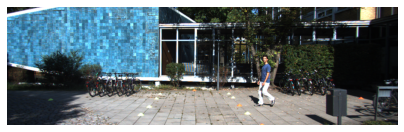

[이미지: stop_2.png] => 예측값: Stop, 정답: Stop
  감지된 객체 1: Pedestrian (confidence: 0.99), 박스 크기: (w=155.7, h=88.5)
------------------------------------------------------------
※ stop_2.png 시각화 창을 띄웁니다...


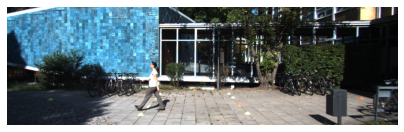

[이미지: stop_3.png] => 예측값: Stop, 정답: Stop
  감지된 객체 1: Car (confidence: 1.00), 박스 크기: (w=168.8, h=304.8)
  감지된 객체 2: Car (confidence: 1.00), 박스 크기: (w=42.3, h=123.5)
  감지된 객체 3: Cyclist (confidence: 0.97), 박스 크기: (w=69.2, h=37.9)
------------------------------------------------------------
※ stop_3.png 시각화 창을 띄웁니다...


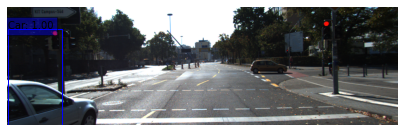

[이미지: stop_4.png] => 예측값: Stop, 정답: Stop
  감지된 객체 1: Car (confidence: 0.99), 박스 크기: (w=75.6, h=116.5)
  감지된 객체 2: Car (confidence: 0.97), 박스 크기: (w=47.5, h=118.8)
  감지된 객체 3: Car (confidence: 0.96), 박스 크기: (w=147.0, h=349.7)
  감지된 객체 4: Van (confidence: 0.95), 박스 크기: (w=329.0, h=390.0)
  감지된 객체 5: Van (confidence: 0.94), 박스 크기: (w=83.9, h=78.4)
  감지된 객체 6: Car (confidence: 0.92), 박스 크기: (w=42.1, h=110.0)
  감지된 객체 7: Van (confidence: 0.85), 박스 크기: (w=45.0, h=98.2)
  감지된 객체 8: Car (confidence: 0.56), 박스 크기: (w=102.0, h=266.1)
------------------------------------------------------------
※ stop_4.png 시각화 창을 띄웁니다...


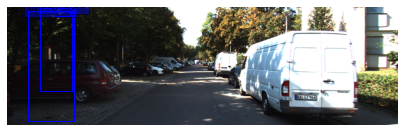

[이미지: stop_5.png] => 예측값: Stop, 정답: Stop
  감지된 객체 1: Car (confidence: 1.00), 박스 크기: (w=194.5, h=373.3)
  감지된 객체 2: Car (confidence: 1.00), 박스 크기: (w=34.5, h=50.0)
  감지된 객체 3: Car (confidence: 1.00), 박스 크기: (w=75.0, h=122.9)
  감지된 객체 4: Car (confidence: 0.94), 박스 크기: (w=29.9, h=42.3)
  감지된 객체 5: Van (confidence: 0.93), 박스 크기: (w=80.3, h=74.0)
  감지된 객체 6: Misc (confidence: 0.62), 박스 크기: (w=34.6, h=56.8)
------------------------------------------------------------
※ stop_5.png 시각화 창을 띄웁니다...


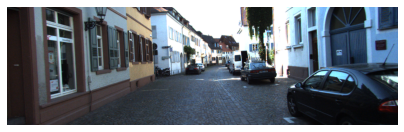

[이미지: go_1.png] => 예측값: Go, 정답: Go
  감지된 객체 1: Car (confidence: 1.00), 박스 크기: (w=31.2, h=32.5)
  감지된 객체 2: Car (confidence: 0.97), 박스 크기: (w=23.9, h=40.0)
  감지된 객체 3: Truck (confidence: 0.97), 박스 크기: (w=29.2, h=62.0)
  감지된 객체 4: Truck (confidence: 0.96), 박스 크기: (w=104.1, h=169.9)
------------------------------------------------------------
※ go_1.png 시각화 창을 띄웁니다...


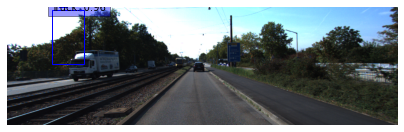

[이미지: go_2.png] => 예측값: Go, 정답: Go
  감지된 객체 1: Car (confidence: 1.00), 박스 크기: (w=40.6, h=38.2)
  감지된 객체 2: Car (confidence: 1.00), 박스 크기: (w=35.1, h=57.2)
  감지된 객체 3: Car (confidence: 0.76), 박스 크기: (w=27.6, h=39.2)
------------------------------------------------------------
※ go_2.png 시각화 창을 띄웁니다...


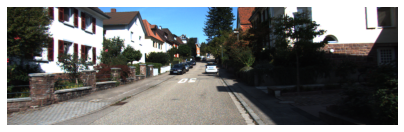

[이미지: go_3.png] => 예측값: Go, 정답: Go
  감지된 객체 1: Car (confidence: 0.97), 박스 크기: (w=28.6, h=90.7)
  감지된 객체 2: Car (confidence: 0.97), 박스 크기: (w=22.1, h=28.6)
------------------------------------------------------------
※ go_3.png 시각화 창을 띄웁니다...


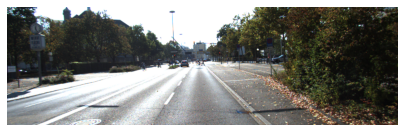

[이미지: go_4.png] => 예측값: Go, 정답: Go
  감지된 객체 1: Car (confidence: 0.98), 박스 크기: (w=78.2, h=99.5)
------------------------------------------------------------
※ go_4.png 시각화 창을 띄웁니다...


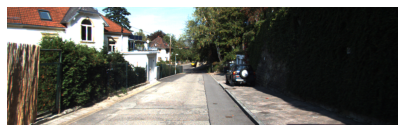

[이미지: go_5.png] => 예측값: Go, 정답: Go
  감지된 객체 1: Car (confidence: 0.99), 박스 크기: (w=75.8, h=209.3)
  감지된 객체 2: Car (confidence: 0.96), 박스 크기: (w=29.0, h=41.4)
  감지된 객체 3: Car (confidence: 0.93), 박스 크기: (w=116.8, h=213.1)
  감지된 객체 4: Car (confidence: 0.89), 박스 크기: (w=44.1, h=102.0)
  감지된 객체 5: Car (confidence: 0.83), 박스 크기: (w=44.9, h=71.2)
------------------------------------------------------------
※ go_5.png 시각화 창을 띄웁니다...


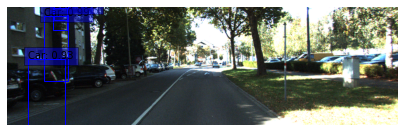

최종 점수: 100점


In [171]:
# 사용 예시:
test_system_with_display_and_bboxes(self_drive_assist)

회고

- FPN(Feature Pyramid Network)을 이용하여 go.stop 시스템을 만들었다.
- 학습을 진행하여 모델의 파라미터 업데이트를 진행하였으며, 15에폭 정도를 진행하였으나 8에폭에서 성능이 가장 좋았다.
- 학습이 충분이 진행되지 않았을 때는 객체를 잘 인식하지 못하는 것을 확인하였다.
- 조건에 맞는 go/stop 시스템을 만들고 평가하였다.
- 추가적으로 판단 근거를 확보하기 위하여 각각의 평가 및 라벨값, 바운딩박스 크기를 받았다.
- 평가사진에 바운딩 박스를 표시하려고 시도하였으나, 잘되지 않았다.
- 추후 추가 실험을 통하여 보완 예정임.